<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Lachin Naghashyar
### Student Number : 98110179
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


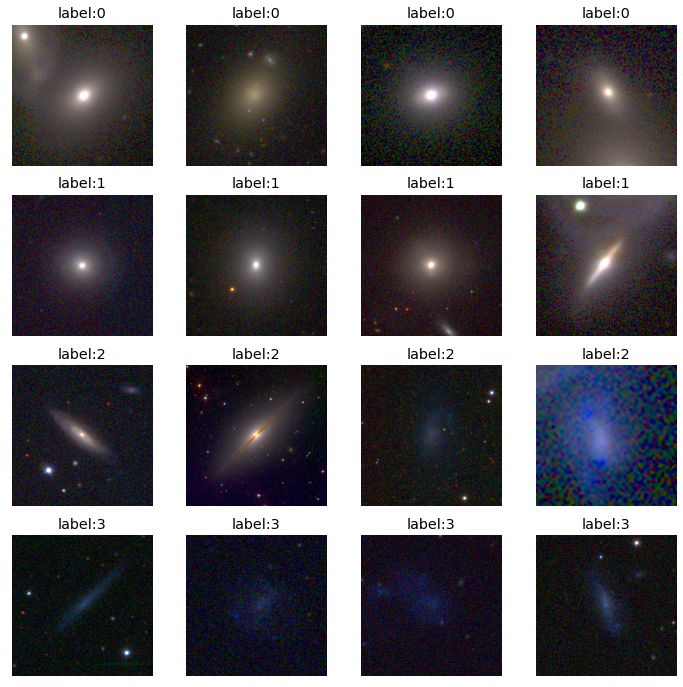

In [4]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
imgs = []
labels = []
for i in range(4):
  class_i = list(df[df.class_label == i]["name"])
  for j in range(4):
    imgs.append(plt.imread('./efigi-1.6/png/'+class_i[j]+'.png'))
    labels.append('label:'+str(i))
for img, ax, label in zip(imgs, axs, labels):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label)
plt.show()



# Define Dataset (20 Points)

In [5]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        img, target = plt.imread('./efigi-1.6/png/'+self.base_dataset.iloc[index,0]+'.png'), self.base_dataset.iloc[index, 2]
        return self.transform(img), target 



# Define Model (20 Points)

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.classifier =  nn.Sequential(
            *linear_relu(input_size, 256),
            *linear_relu(256, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        return y

# Train Model (30 Points)

In [7]:
test_ratio = 0.3
valid_ratio = 0.2 
nb_train_valid = int((1.0 - test_ratio) * len(df))
nb_test =  len(df) - nb_train_valid

dataset = GalaxyDataSet(df, transforms.ToTensor())
train_valid_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, [nb_train_valid, nb_test])

nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
print(train_dataset)

# train_dataset = GalaxyDataSet(train_dataset, transforms.ToTensor())
# valid_dataset = GalaxyDataSet(valid_dataset, transforms.ToTensor())
# test_dataset  = GalaxyDataSet(test_dataset , transforms.ToTensor())

num_threads = 2     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                # <-- this reshuffles the data at every epoch
                                          num_workers=num_threads)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 2496 images, in 20 batches
The validation set contains 624 images, in 5 batches
The test set contains 1338 images, in 11 batches


In [8]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
# model=ClassifierModel(255*255*3, 10)
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters())
# f_loss = torch.nn.CrossEntropyLoss()

def train(model, loader, f_loss, optimizer, device):
    # We enter train mode.
    # it is important for layers such as dropout, batchnorm, ...
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the forward pass through the network up to the loss
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(model, loader, f_loss, device):
    # We disable gradient computation which speeds up the computation
    # and reduces the memory usage
    with torch.no_grad():
        # We enter evaluation mode.
        # it is important with layers such as dropout, batchnorm, ..
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):

            # We got a minibatch from the loader within inputs and targets
  
            # We need to copy the data on the GPU if we use one
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass, i.e. the scores for each input image
            outputs = model(inputs)

            # We accumulate the exact number of processed samples
            N += inputs.shape[0]

            # We accumulate the loss considering
            # The multipliation by inputs.shape[0] is due to the fact
            # that our loss criterion is averaging over its samples
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            # For the accuracy, we compute the labels for each input image
            # Be carefull, the model is outputing scores and not the probabilities
            # But given the softmax is not altering the rank of its input scores
            # we can compute the label by argmaxing directly the scores
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N

Epoch 0
 Training : Loss : 1.1166, Acc : 0.7504
 Validation : Loss : 1.2977, Acc : 0.7147
Epoch 1
 Training : Loss : 0.8643, Acc : 0.7504
 Validation : Loss : 0.9401, Acc : 0.7147
Epoch 2
 Training : Loss : 0.6824, Acc : 0.7584
 Validation : Loss : 0.7822, Acc : 0.7163
Epoch 3
 Training : Loss : 0.5933, Acc : 0.7668
 Validation : Loss : 0.7219, Acc : 0.7324
Epoch 4
 Training : Loss : 0.4722, Acc : 0.8498
 Validation : Loss : 0.6510, Acc : 0.7388
Epoch 5
 Training : Loss : 0.4070, Acc : 0.8217
 Validation : Loss : 0.6836, Acc : 0.7276
Epoch 6
 Training : Loss : 0.3104, Acc : 0.9423
 Validation : Loss : 0.6030, Acc : 0.7788
Epoch 7
 Training : Loss : 0.2571, Acc : 0.9151
 Validation : Loss : 0.6779, Acc : 0.7436
Epoch 8
 Training : Loss : 0.2251, Acc : 0.9135
 Validation : Loss : 0.7905, Acc : 0.7292
Epoch 9
 Training : Loss : 0.1786, Acc : 0.9391
 Validation : Loss : 0.8444, Acc : 0.7244


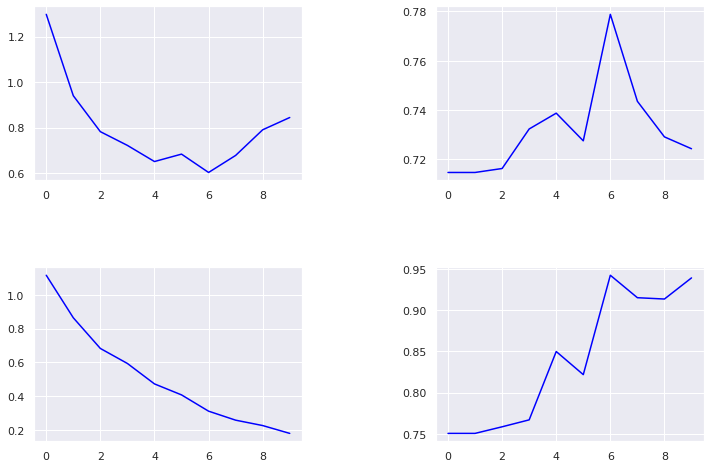

In [34]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
model=ClassifierModel(255*255*3, 10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()


def train_plot_metrics(epochs, model, optimizer):
    FC1 = []
    FC2 = []
    FC3 = []
    FC4 = []
    for t in range(epochs):
        print("Epoch {}".format(t))
        train(model, train_loader, f_loss, optimizer, device)
        val_loss, val_acc = test(model, valid_loader, f_loss, device)
        train_loss, train_acc = test(model, train_loader, f_loss, device)
        FC1.append(val_loss)
        FC2.append(val_acc)
        FC3.append(train_loss)
        FC4.append(train_acc)
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
        # model_checkpoint.update(val_loss)

    import seaborn as sns
    sns.set()
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    sns.lineplot(data=FC1, ax=axes[0, 0], color='blue');
    sns.lineplot(data=FC2, ax=axes[0, 1], color='blue');
    sns.lineplot(data=FC3, ax=axes[1, 0], color='blue');
    sns.lineplot(data=FC4, ax=axes[1, 1], color='blue');

train_plot_metrics(10, model, optimizer)

# Test Model (20)

test loss: 0.7738755804184485 , test acc: 0.7481315396113603


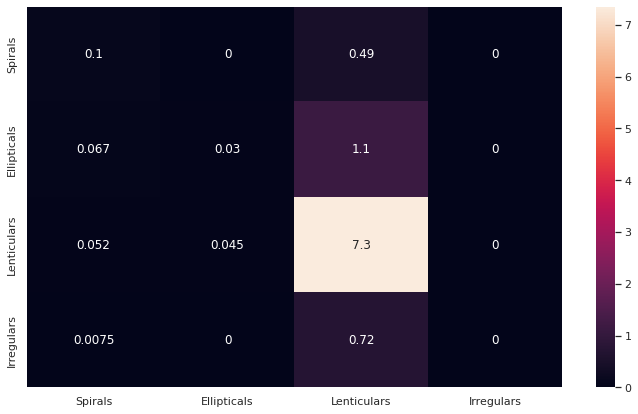

In [35]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
# got help from the tutorial here: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
def test_plot_confusion(model):
    test_loss, test_acc = test(model, test_loader, f_loss, device)
    print('test loss: '+str(test_loss) +' , test acc: '+str(test_acc))
    y_pred = []
    y_true = []

    with torch.no_grad():
            model.eval()
            N = 0
            tot_loss, correct = 0.0, 0.0
            for i, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
                y_pred.extend(output)

                tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

                targets = targets.data.cpu().numpy()
                y_true.extend(targets)
        
                inputs = inputs.data.cpu().numpy()
                N += inputs.shape[0]
                
                correct += (output == targets).sum().item()
            tot_loss/N, correct/N

    # constant for classes
    classes = ('Spirals', 'Ellipticals', 'Lenticulars','Irregulars')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('confusion_mat.png')
    
test_plot_confusion(model)    

We can also test this on some other models:

Epoch 0
 Training : Loss : 1.3085, Acc : 0.7504
 Validation : Loss : 1.5040, Acc : 0.7147
Epoch 1
 Training : Loss : 0.8075, Acc : 0.7504
 Validation : Loss : 0.9086, Acc : 0.7147
Epoch 2
 Training : Loss : 0.7014, Acc : 0.7508
 Validation : Loss : 0.8230, Acc : 0.7147
Epoch 3
 Training : Loss : 0.6057, Acc : 0.8273
 Validation : Loss : 0.7163, Acc : 0.7532
Epoch 4
 Training : Loss : 0.4441, Acc : 0.8425
 Validation : Loss : 0.6320, Acc : 0.7372
Epoch 5
 Training : Loss : 0.3440, Acc : 0.9075
 Validation : Loss : 0.6091, Acc : 0.7532
Epoch 6
 Training : Loss : 0.3833, Acc : 0.8205
 Validation : Loss : 0.8372, Acc : 0.7196
Epoch 7
 Training : Loss : 0.2694, Acc : 0.9507
 Validation : Loss : 0.6619, Acc : 0.7404
Epoch 8
 Training : Loss : 0.2250, Acc : 0.9403
 Validation : Loss : 0.6926, Acc : 0.7179
Epoch 9
 Training : Loss : 0.0992, Acc : 0.9824
 Validation : Loss : 0.7240, Acc : 0.7404
test loss: 0.6611649971371809 , test acc: 0.7593423019431988


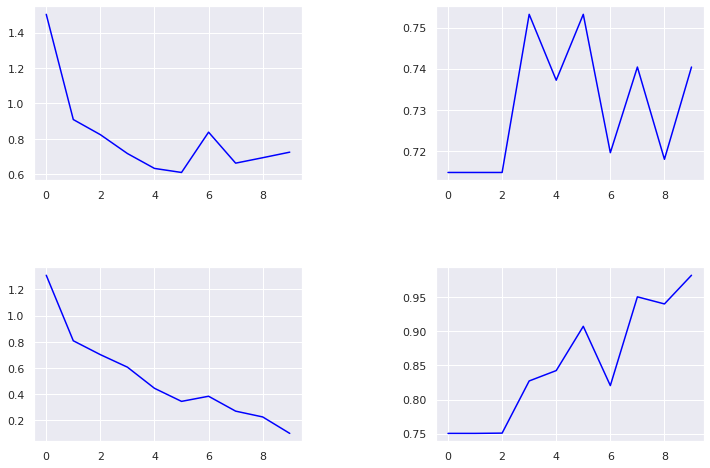

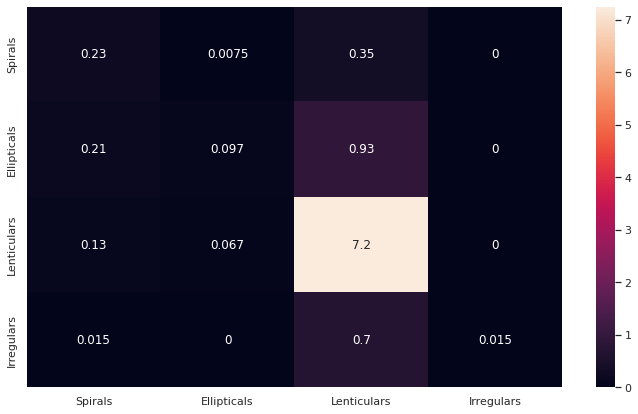

In [30]:
class FullyConnectedRegularized(nn.Module):

    def __init__(self, input_size, num_classes, l2_reg):
        super(FullyConnectedRegularized, self).__init__()
        self.l2_reg = l2_reg
        self.lin1 = nn.Linear(input_size, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, num_classes)


    def penalty(self):
        return self.l2_reg * (self.lin1.weight.norm(2) + self.lin2.weight.norm(2) + self.lin3.weight.norm(2))

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = nn.functional.relu(self.lin2(x))
        y = self.lin3(x)
        return y

model = FullyConnectedRegularized(3*255*255, 10, 0.01)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

train_plot_metrics(10, model, optimizer)
test_plot_confusion(model)

Epoch 0
 Training : Loss : 1.4909, Acc : 0.7508
 Validation : Loss : 1.7614, Acc : 0.7147
Epoch 1
 Training : Loss : 0.6607, Acc : 0.7576
 Validation : Loss : 0.7909, Acc : 0.7179
Epoch 2
 Training : Loss : 0.5789, Acc : 0.7560
 Validation : Loss : 0.7202, Acc : 0.7163
Epoch 3
 Training : Loss : 0.5475, Acc : 0.7612
 Validation : Loss : 0.7437, Acc : 0.7212
Epoch 4
 Training : Loss : 0.5216, Acc : 0.7616
 Validation : Loss : 0.6777, Acc : 0.7212
Epoch 5
 Training : Loss : 0.4402, Acc : 0.8233
 Validation : Loss : 0.6254, Acc : 0.7340
Epoch 6
 Training : Loss : 0.4190, Acc : 0.7760
 Validation : Loss : 0.6789, Acc : 0.7163
Epoch 7
 Training : Loss : 0.3591, Acc : 0.9030
 Validation : Loss : 0.5959, Acc : 0.7420
Epoch 8
 Training : Loss : 0.3539, Acc : 0.8618
 Validation : Loss : 0.6404, Acc : 0.7292
Epoch 9
 Training : Loss : 0.3492, Acc : 0.8129
 Validation : Loss : 0.7442, Acc : 0.7324
test loss: 0.6874495133512579 , test acc: 0.750373692077728


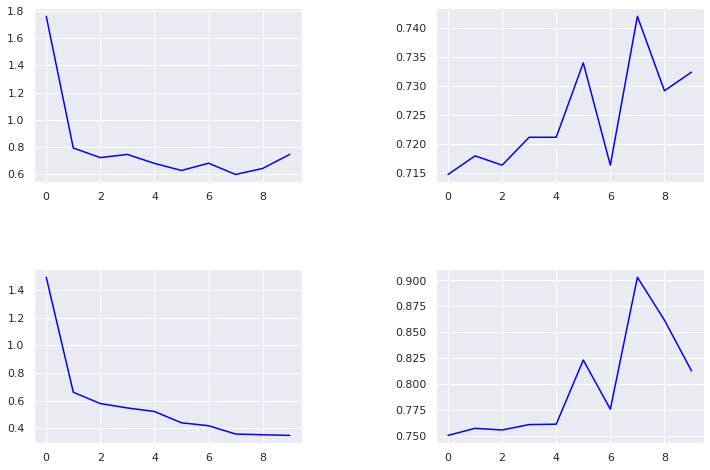

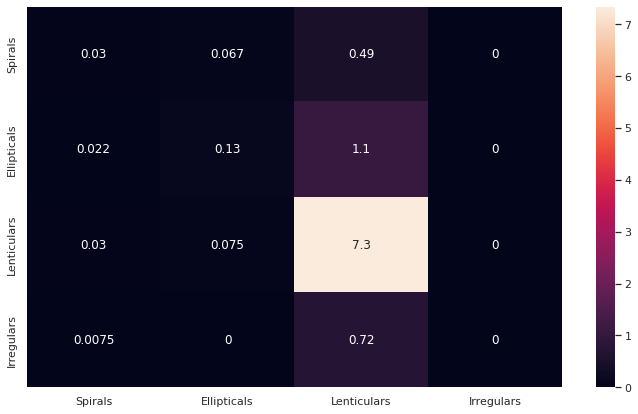

In [33]:
class DropoutRegularized(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DropoutRegularized, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        return y

model = DropoutRegularized(3*255*255, 10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

train_plot_metrics(10, model, optimizer)
test_plot_confusion(model)

As you can see, models have test accuracy of 74, 75 and 75 when trained for 10 epochs.